# Predicting Mutation Type Based on Sequencing Data

## Introduction
In this lab project, we aim to predict the mutation type based on sequencing data from two datasets: The Cancer Genome Atlas (TCGA) and the Cancer Cell Line Encyclopedia (CCLE). Specifically, we will be focusing on the `Variant_Class` column to identify mutation types such as `Missense_Mutation`.

The goal is to compare three classification approaches:
1. Random Forest
2. XGBoost
3. Deep Neural Network (Multi-Layer Perceptron)

We will use best practices such as balancing the dataset and evaluating the models using metrics like AUC and confusion matrices.

# PROBLEMS TO ADRESS: HOW TO REBALANCE -> SOME MUTATIONS OCCUR ONCE. AND MAKE SURE THEY OCCUR BOTH IN TRAIN AND TEST.


## Data Description and Exploration
The TCGA and CCLE datasets provide comprehensive genomic data. The TCGA dataset includes over 20,000 primary cancer and matched normal samples spanning 33 cancer types. The CCLE dataset includes cancer cell lines used to study cancer biology.

We will perform exploratory data analysis (EDA) to understand the data distributions, check for missing values, and visualize key features.


In [22]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample

##### Colab

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
tcga_file = "/content/drive/MyDrive/ML_LAB/TCGA.csv"
ccle_file = "/content/drive/MyDrive/ML_LAB/CCLE.csv"

##### Local

In [2]:
tcga_file = "TCGA.csv"
ccle_file = "CCLE.csv"

# ADD HERE EXPLORATION, HOW MANY MUTATIONS OF WHICH TYPE

## Data Preprocessing
To prepare the data for modeling, we need to:
1. Encode categorical variables.
2. Handle missing values.
3. Balance the dataset if necessary.
4. Split the data into training and testing sets.


In [3]:
# Load the datasets
tcga_data = pd.read_csv(tcga_file)
ccle_data = pd.read_csv(ccle_file)
# Display the first few rows of each dataset
# print("TCGA Data:")
# print(tcga_data.head())

# print("\nCCLE Data:")
# print(ccle_data.head())

In [4]:
# Define a function to extract the mutation type
def extract_mutation_type(variant):
    pattern = r"(nonsense|in_frame_del|in_frame_ins|fusion|translation|frame_shift_del|frame_shift_ins|splice|missense|silent)"
    match = re.search(pattern, variant, re.IGNORECASE)
    if match:
        return match.group(0).replace(" ", "_").replace("-", "_").lower()
    else:
        return "other"


# Apply the function to extract mutation types
tcga_data["Mutation_Type_Label"] = tcga_data["Variant_Classification"].apply(
    extract_mutation_type
)
ccle_data["Mutation_Type_Label"] = ccle_data["Variant_Classification"].apply(
    extract_mutation_type
)

# Remove rows with the "translation" type of mutation from the TCGA dataset
tcga_data = tcga_data[tcga_data["Mutation_Type_Label"] != "translation"]

# Print the counts for each category in Mutation_Type for both datasets
print("TCGA data: Counts for each Mutation_Type category")
tcga_counts = tcga_data["Mutation_Type_Label"].value_counts()
print(tcga_counts)

print("\nCCLE data: Counts for each Mutation_Type category")
ccle_counts = ccle_data["Mutation_Type_Label"].value_counts()
print(ccle_counts)

TCGA data: Counts for each Mutation_Type category
Mutation_Type_Label
missense           2707
nonsense            547
frame_shift_del     392
splice              328
frame_shift_ins     121
in_frame_del         76
fusion               25
in_frame_ins         14
Name: count, dtype: int64

CCLE data: Counts for each Mutation_Type category
Mutation_Type_Label
missense           604
nonsense           103
splice             102
frame_shift_del     74
frame_shift_ins     22
in_frame_del        16
in_frame_ins         3
Name: count, dtype: int64


In [5]:
# Encode the target variable


label_encoder_tcga = LabelEncoder()


label_encoder_ccle = LabelEncoder()

tcga_data["Mutation_Type"] = label_encoder_tcga.fit_transform(
    tcga_data["Mutation_Type_Label"]
)


ccle_data["Mutation_Type"] = label_encoder_ccle.fit_transform(
    ccle_data["Mutation_Type_Label"]
)

tcga_data["Missense"] = np.where(
    tcga_data["Mutation_Type_Label"] == "missense", "Missense", "Other"
)


ccle_data["Mutation_Type"] = label_encoder_ccle.fit_transform(
    ccle_data["Mutation_Type"]
)

ccle_data["Missense"] = np.where(
    ccle_data["Mutation_Type_Label"] == "missense", "Missense", "Other"
)

# Prepare features and target for TCGA data


X_tcga = tcga_data.drop(
    ["Variant_Classification", "Mutation_Type_Label", "Mutation_Type", "Missense"],
    axis=1,
)


y_tcga = tcga_data["Mutation_Type"]


# Prepare features and target for CCLE data


X_ccle = ccle_data.drop(
    ["Variant_Classification", "Mutation_Type_Label", "Mutation_Type", "Missense"],
    axis=1,
)


y_ccle = ccle_data["Mutation_Type"]


# Split the data into training and testing sets


X_train_tcga, X_test_tcga, y_train_tcga, y_test_tcga = train_test_split(
    X_tcga, y_tcga, test_size=0.2, random_state=42, stratify=y_tcga
)


X_train_ccle, X_test_ccle, y_train_ccle, y_test_ccle = train_test_split(
    X_ccle, y_ccle, test_size=0.2, random_state=42, stratify=y_ccle
)  # Encode the target variable


# Identify categorical columns


categorical_cols_tcga = X_tcga.select_dtypes(include=["object"]).columns


categorical_cols_ccle = X_ccle.select_dtypes(include=["object"]).columns


# TODO: is it correct encoding of columns?


# Create a column transformer with one-hot encoding for categorical features


preprocessor_tcga = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols_tcga)
    ],
    remainder="passthrough",
)


preprocessor_ccle = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols_ccle)
    ],
    remainder="passthrough",
)

#### T-SNE

In [16]:
def create_tsne_graph(X: pd.DataFrame, df: pd.DataFrame, column: str, title: str):
    tsne = TSNE(n_components=2, random_state=42)

    tsne = tsne.fit_transform(X)

    # Get unique labels and create a color map
    unique_labels = df[column].unique()
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_labels))))
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert string labels to numeric labels for coloring
    numeric_labels = df[column].map(label_to_color)

    plt.scatter(tsne[:, 0], tsne[:, 1], c=numeric_labels, cmap=cmap)
    plt.title(title)
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")

    # Custom legend
    handles = [
        plt.Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=cmap(i), markersize=10
        )
        for i in range(len(unique_labels))
    ]
    plt.legend(handles, unique_labels, title="Mutation Type", loc="best")

    plt.show()

In [13]:
def create_tsne_graph_3d(X: pd.DataFrame, df: pd.DataFrame, column: str, title: str):
    tsne = TSNE(n_components=3, random_state=42)

    tsne_results = tsne.fit_transform(X)

    # Get unique labels and create a color map
    unique_labels = df[column].unique()
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_labels))))
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert string labels to numeric labels for coloring
    numeric_labels = df[column].map(label_to_color)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(
        tsne_results[:, 0],
        tsne_results[:, 1],
        tsne_results[:, 2],
        c=numeric_labels,
        cmap=cmap,
    )
    ax.set_title(title)
    ax.set_xlabel("t-SNE component 1")
    ax.set_ylabel("t-SNE component 2")
    ax.set_zlabel("t-SNE component 3")

    # Custom legend
    handles = [
        plt.Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=cmap(i), markersize=10
        )
        for i in range(len(unique_labels))
    ]
    ax.legend(handles, unique_labels, title="Mutation Type", loc="best")

    plt.show()

##### TCGA

Mutation type

c:\ProgramData\miniforge3\envs\mllab\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


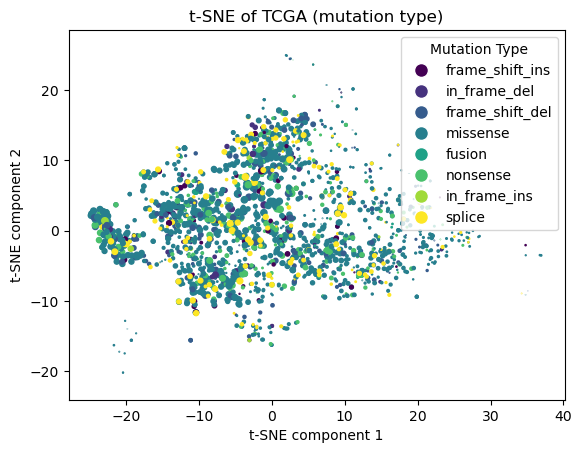

In [14]:
create_tsne_graph(
    X_tcga, tcga_data, "Mutation_Type_Label", "t-SNE of TCGA (mutation type)"
)

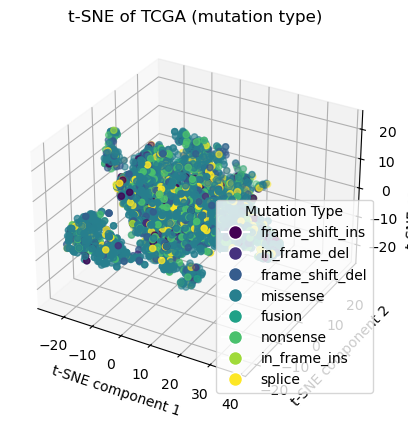

In [15]:
create_tsne_graph_3d(
    X_tcga, tcga_data, "Mutation_Type_Label", "t-SNE of TCGA (mutation type)"
)

Missense vs all

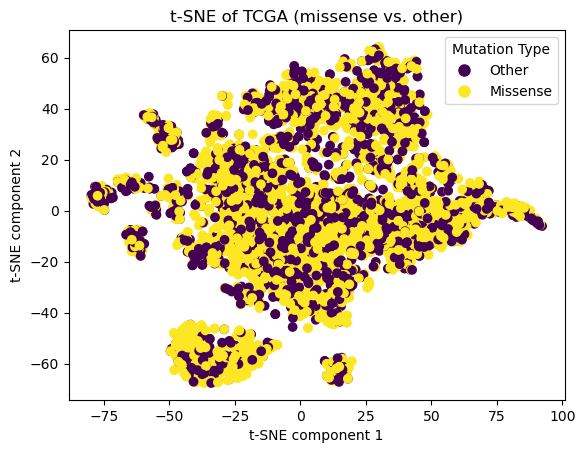

In [8]:
create_tsne_graph(X_tcga, tcga_data, "Missense", "t-SNE of TCGA (missense vs. other)")

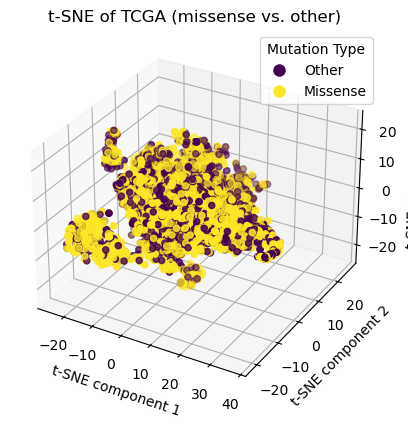

In [17]:
create_tsne_graph_3d(
    X_tcga, tcga_data, "Missense", "t-SNE of TCGA (missense vs. other)"
)

##### CCLE

Mutation type

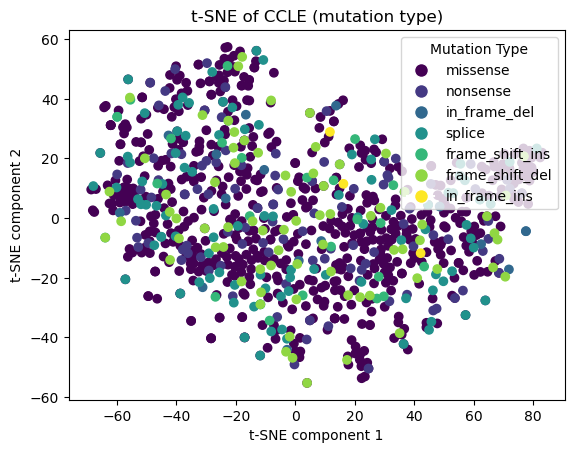

In [9]:
create_tsne_graph(
    X_ccle, ccle_data, "Mutation_Type_Label", "t-SNE of CCLE (mutation type)"
)

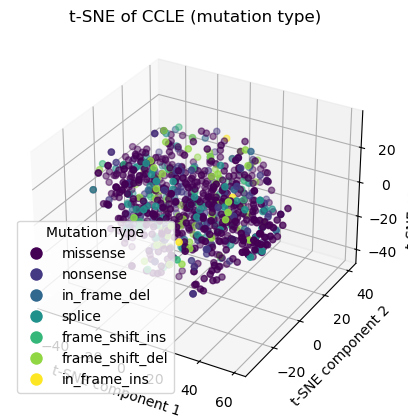

In [18]:
create_tsne_graph_3d(
    X_ccle, ccle_data, "Mutation_Type_Label", "t-SNE of CCLE (mutation type)"
)

Missense vs all

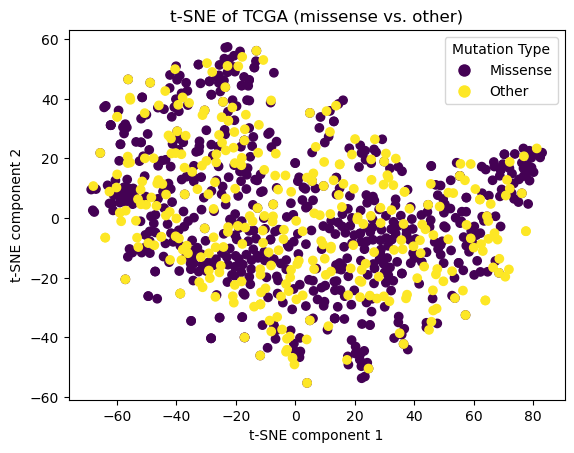

In [10]:
create_tsne_graph(X_ccle, ccle_data, "Missense", "t-SNE of TCGA (missense vs. other)")

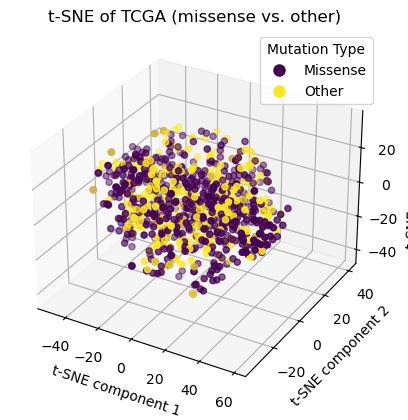

In [19]:
create_tsne_graph_3d(
    X_ccle, ccle_data, "Missense", "t-SNE of TCGA (missense vs. other)"
)

##### Random Forest

Random Forest Cross-Validation Accuracy scores (TCGA): [0.62243989 0.62600178 0.63547237]
Random Forest Mean Cross-Validation Accuracy score (TCGA): 0.6279713482845849


c:\ProgramData\miniforge3\envs\mllab\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest Metrics on TCGA Test Data:
Accuracy: 0.6271
Precision: 0.4668
Recall: 0.6271
F1 Score: 0.5092


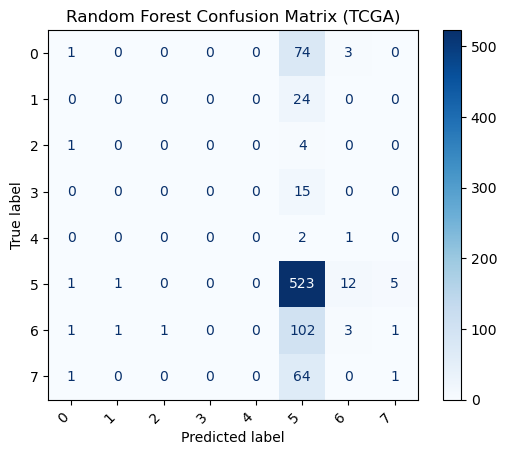

In [13]:
# Create a pipeline with preprocessing and classifier for TCGA data
pipeline_tcga = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tcga),
        ("classifier", RandomForestClassifier(random_state=42, criterion="entropy")),
    ]
)

# Perform 10-fold cross-validation on TCGA data
cv_scores_tcga = cross_val_score(
    pipeline_tcga, X_train_tcga, y_train_tcga, cv=3, scoring="accuracy"
)
print("Random Forest Cross-Validation Accuracy scores (TCGA):", cv_scores_tcga)
print(
    "Random Forest Mean Cross-Validation Accuracy score (TCGA):",
    np.mean(cv_scores_tcga),
)

# Train the model on TCGA data
pipeline_tcga.fit(X_train_tcga, y_train_tcga)

# Predict on the TCGA test set
y_pred_rf_tcga = pipeline_tcga.predict(X_test_tcga)

# Evaluate the model with additional metrics for TCGA data
accuracy_rf_tcga = accuracy_score(y_test_tcga, y_pred_rf_tcga)
precision_rf_tcga = precision_score(y_test_tcga, y_pred_rf_tcga, average="weighted")
recall_rf_tcga = recall_score(y_test_tcga, y_pred_rf_tcga, average="weighted")
f1_rf_tcga = f1_score(y_test_tcga, y_pred_rf_tcga, average="weighted")

# Print metrics for TCGA data
print("\nRandom Forest Metrics on TCGA Test Data:")
print(f"Accuracy: {accuracy_rf_tcga:.4f}")
print(f"Precision: {precision_rf_tcga:.4f}")
print(f"Recall: {recall_rf_tcga:.4f}")
print(f"F1 Score: {f1_rf_tcga:.4f}")

# Confusion matrix for TCGA data # test data does not include all labels
cm_rf_tcga = confusion_matrix(y_test_tcga, y_pred_rf_tcga)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf_tcga, display_labels=label_encoder_tcga.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix (TCGA)")
plt.xticks(rotation=45, ha="right")
plt.show()

# Collect metrics in a DataFrame for TCGA data
rf_metrics_tcga = pd.DataFrame(
    {
        "Model": ["Random Forest (TCGA)"],
        "Accuracy": [accuracy_rf_tcga],
        "Precision": [precision_rf_tcga],
        "Recall": [recall_rf_tcga],
        "F1 Score": [f1_rf_tcga],
    }
)

Hyperparameter tuning

In [ ]:
from datetime import datetime
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
from optuna.study import create_study, load_study


def hyperparameter_search(dataset : str, classifier : ):
    study_name = f"rf-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
    random_state = 42
    previous_trials = []
    for file in os.listdir("."):
        if file.startswith("tfidf-predictor") and file.endswith(".db"):
            previous_trials = (
                previous_trials + load_study(None, storage=f"sqlite:///{file}").trials
            )
    study = create_study(
        study_name=study_name, storage=f"sqlite:///{study_name}.db", direction="maximize"
    )
    study.add_trials(previous_trials)

    opt = OptunaSearchCV(
        classifier,
        study=study,
        param_distributions={
            "lowercase": CategoricalDistribution([True, False]),
            "stop_words": CategoricalDistribution([None, "english"]),
            "token_pattern": CategoricalDistribution([r"(?u)\b\w\w+\b", r"\S+"]),
            "ngram_range": CategoricalDistribution(
                [
                    "(1, 1)",
                    "(1,2)",
                    "(1,3)",
                    "(1,4)",
                    "(1,5)",
                    "(2,2)",
                    "(2,3)",
                    "(2,4)",
                    "(2,5)",
                ]
            ),
            "max_df": FloatDistribution(0.95, 1.0),
            "min_df": FloatDistribution(0.0, 0.1),
            "binary": CategoricalDistribution([True, False]),
            "use_idf": CategoricalDistribution([True, False]),
            "smooth_idf": CategoricalDistribution([True, False]),
            "sublinear_tf": CategoricalDistribution([True, False]),
            "column": CategoricalDistribution(
                [column for column in all_df.columns if "user_prompt" in column]
            ),
        },
        cv=KFold(n_splits=4, shuffle=True, random_state=random_state),
        n_jobs=2,
        n_trials=5000,
        random_state=random_state,
    )
opt.fit(all_df, all_df["model_response"])

c:\ProgramData\miniforge3\envs\mllab\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



Random Forest Cross-Validation Accuracy scores (CCLE): [0.61133603 0.63414634 0.6097561 ]
Random Forest Mean Cross-Validation Accuracy score (CCLE): 0.6184128238043515


c:\ProgramData\miniforge3\envs\mllab\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest Metrics on CCLE Test Data:
Accuracy: 0.6486
Precision: 0.5001
Recall: 0.6486
F1 Score: 0.5619


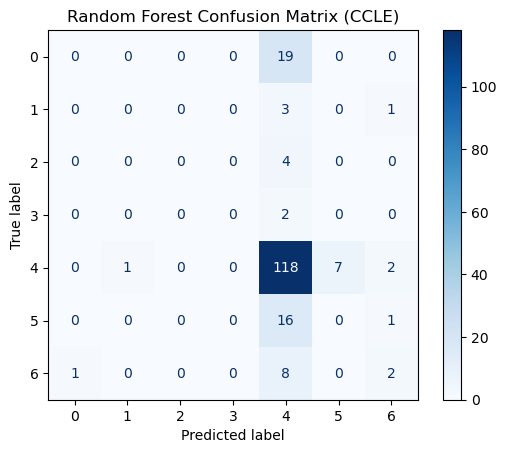


All Metrics:
                  Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (TCGA)  0.616390   0.462179  0.616390  0.510111
1  Random Forest (CCLE)  0.648649   0.500074  0.648649  0.561932


In [7]:
# Create a pipeline with preprocessing and classifier for CCLE data
pipeline_ccle = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ccle),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Perform 10-fold cross-validation on CCLE data
cv_scores_ccle = cross_val_score(
    pipeline_ccle, X_train_ccle, y_train_ccle, cv=3, scoring="accuracy"
)
print("\nRandom Forest Cross-Validation Accuracy scores (CCLE):", cv_scores_ccle)
print(
    "Random Forest Mean Cross-Validation Accuracy score (CCLE):",
    np.mean(cv_scores_ccle),
)

# Train the model on CCLE data
pipeline_ccle.fit(X_train_ccle, y_train_ccle)

# Predict on the CCLE test set
y_pred_rf_ccle = pipeline_ccle.predict(X_test_ccle)

# Evaluate the model with additional metrics for CCLE data
accuracy_rf_ccle = accuracy_score(y_test_ccle, y_pred_rf_ccle)
precision_rf_ccle = precision_score(y_test_ccle, y_pred_rf_ccle, average="weighted")
recall_rf_ccle = recall_score(y_test_ccle, y_pred_rf_ccle, average="weighted")
f1_rf_ccle = f1_score(y_test_ccle, y_pred_rf_ccle, average="weighted")

# Print metrics for CCLE data
print("\nRandom Forest Metrics on CCLE Test Data:")
print(f"Accuracy: {accuracy_rf_ccle:.4f}")
print(f"Precision: {precision_rf_ccle:.4f}")
print(f"Recall: {recall_rf_ccle:.4f}")
print(f"F1 Score: {f1_rf_ccle:.4f}")

# Confusion matrix for CCLE data
cm_rf_ccle = confusion_matrix(y_test_ccle, y_pred_rf_ccle)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf_ccle, display_labels=label_encoder_ccle.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix (CCLE)")
plt.show()

# Collect metrics in a DataFrame for CCLE data
rf_metrics_ccle = pd.DataFrame(
    {
        "Model": ["Random Forest (CCLE)"],
        "Accuracy": [accuracy_rf_ccle],
        "Precision": [precision_rf_ccle],
        "Recall": [recall_rf_ccle],
        "F1 Score": [f1_rf_ccle],
    }
)

# Combine all metrics into a single DataFrame
all_metrics = pd.concat([rf_metrics_tcga, rf_metrics_ccle], ignore_index=True)
print("\nAll Metrics:")
print(all_metrics)

### XGBoost
Next, we will use XGBoost, a powerful gradient boosting algorithm.

XGBoost Cross-Validation Accuracy scores (TCGA): [0.61531612 0.61976848 0.61942959]
XGBoost Mean Cross-Validation Accuracy score (TCGA): 0.6181713949510294


c:\ProgramData\miniforge3\envs\mllab\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



XGBoost Metrics on TCGA Test Data:
Accuracy: 0.6081
Precision: 0.4566
Recall: 0.6081
F1 Score: 0.5057


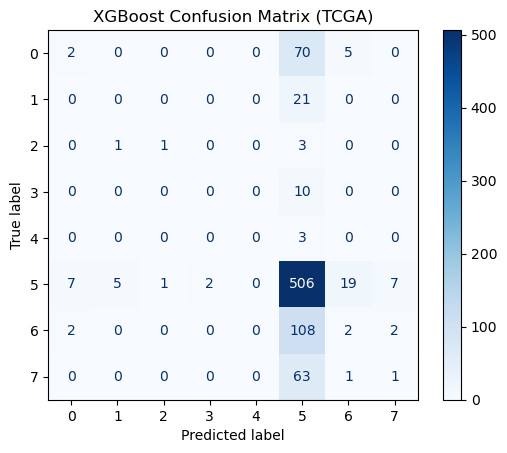

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

# Create a pipeline with preprocessing and classifier for TCGA data
pipeline_tcga_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tcga),
        (
            "classifier",
            XGBClassifier(
                random_state=42, use_label_encoder=False, eval_metric="mlogloss"
            ),
        ),
    ]
)

# Perform 10-fold cross-validation on TCGA data
cv_scores_tcga_xgb = cross_val_score(
    pipeline_tcga_xgb, X_train_tcga, y_train_tcga, cv=3, scoring="accuracy"
)
print("XGBoost Cross-Validation Accuracy scores (TCGA):", cv_scores_tcga_xgb)
print(
    "XGBoost Mean Cross-Validation Accuracy score (TCGA):", np.mean(cv_scores_tcga_xgb)
)

# Train the model on TCGA data
pipeline_tcga_xgb.fit(X_train_tcga, y_train_tcga)

# Predict on the TCGA test set
y_pred_xgb_tcga = pipeline_tcga_xgb.predict(X_test_tcga)

# Evaluate the model with additional metrics for TCGA data
accuracy_xgb_tcga = accuracy_score(y_test_tcga, y_pred_xgb_tcga)
precision_xgb_tcga = precision_score(y_test_tcga, y_pred_xgb_tcga, average="weighted")
recall_xgb_tcga = recall_score(y_test_tcga, y_pred_xgb_tcga, average="weighted")
f1_xgb_tcga = f1_score(y_test_tcga, y_pred_xgb_tcga, average="weighted")

# Print metrics for TCGA data
print("\nXGBoost Metrics on TCGA Test Data:")
print(f"Accuracy: {accuracy_xgb_tcga:.4f}")
print(f"Precision: {precision_xgb_tcga:.4f}")
print(f"Recall: {recall_xgb_tcga:.4f}")
print(f"F1 Score: {f1_xgb_tcga:.4f}")

# Confusion matrix for TCGA data
cm_xgb_tcga = confusion_matrix(y_test_tcga, y_pred_xgb_tcga)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb_tcga, display_labels=label_encoder_tcga.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix (TCGA)")
plt.show()

# Collect metrics in a DataFrame for TCGA data
xgb_metrics_tcga = pd.DataFrame(
    {
        "Model": ["XGBoost (TCGA)"],
        "Accuracy": [accuracy_xgb_tcga],
        "Precision": [precision_xgb_tcga],
        "Recall": [recall_xgb_tcga],
        "F1 Score": [f1_xgb_tcga],
    }
)

In [ ]:
# Create a pipeline with preprocessing and classifier for CCLE data
pipeline_ccle_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ccle),
        (
            "classifier",
            XGBClassifier(
                random_state=42, use_label_encoder=False, eval_metric="mlogloss"
            ),
        ),
    ]
)

# Perform 10-fold cross-validation on CCLE data
cv_scores_ccle_xgb = cross_val_score(
    pipeline_ccle_xgb, X_train_ccle, y_train_ccle, cv=3, scoring="accuracy"
)
print("\nXGBoost Cross-Validation Accuracy scores (CCLE):", cv_scores_ccle_xgb)
print(
    "XGBoost Mean Cross-Validation Accuracy score (CCLE):", np.mean(cv_scores_ccle_xgb)
)

# Train the model on CCLE data
pipeline_ccle_xgb.fit(X_train_ccle, y_train_ccle)

# Predict on the CCLE test set
y_pred_xgb_ccle = pipeline_ccle_xgb.predict(X_test_ccle)

# Evaluate the model with additional metrics for CCLE data
accuracy_xgb_ccle = accuracy_score(y_test_ccle, y_pred_xgb_ccle)
precision_xgb_ccle = precision_score(y_test_ccle, y_pred_xgb_ccle, average="weighted")
recall_xgb_ccle = recall_score(y_test_ccle, y_pred_xgb_ccle, average="weighted")
f1_xgb_ccle = f1_score(y_test_ccle, y_pred_xgb_ccle, average="weighted")

# Print metrics for CCLE data
print("\nXGBoost Metrics on CCLE Test Data:")
print(f"Accuracy: {accuracy_xgb_ccle:.4f}")
print(f"Precision: {precision_xgb_ccle:.4f}")
print(f"Recall: {recall_xgb_ccle:.4f}")
print(f"F1 Score: {f1_xgb_ccle:.4f}")

# Confusion matrix for CCLE data
cm_xgb_ccle = confusion_matrix(y_test_ccle, y_pred_xgb_ccle)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb_ccle, display_labels=label_encoder_ccle.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix (CCLE)")
plt.show()

# Collect metrics in a DataFrame for CCLE data
xgb_metrics_ccle = pd.DataFrame(
    {
        "Model": ["XGBoost (CCLE)"],
        "Accuracy": [accuracy_xgb_ccle],
        "Precision": [precision_xgb_ccle],
        "Recall": [recall_xgb_ccle],
        "F1 Score": [f1_xgb_ccle],
    }
)

# Combine all metrics into a single DataFrame for XGBoost
xgb_all_metrics = pd.concat([xgb_metrics_tcga, xgb_metrics_ccle], ignore_index=True)
print("\nXGBoost All Metrics:")
print(xgb_all_metrics)

### Deep Neural Network (Multi-Layer Perceptron)
Finally, we will use a Deep Neural Network implemented with PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tcga_tensor = torch.tensor(
    preprocessor_tcga.fit_transform(X_train_tcga), dtype=torch.float32
)
y_train_tcga_tensor = torch.tensor(y_train_tcga.values, dtype=torch.long)
X_test_tcga_tensor = torch.tensor(
    preprocessor_tcga.transform(X_test_tcga), dtype=torch.float32
)
y_test_tcga_tensor = torch.tensor(y_test_tcga.values, dtype=torch.long)

X_train_ccle_tensor = torch.tensor(
    preprocessor_ccle.fit_transform(X_train_ccle), dtype=torch.float32
)
y_train_ccle_tensor = torch.tensor(y_train_ccle.values, dtype=torch.long)
X_test_ccle_tensor = torch.tensor(
    preprocessor_ccle.transform(X_test_ccle), dtype=torch.float32
)
y_test_ccle_tensor = torch.tensor(y_test_ccle.values, dtype=torch.long)

# Create DataLoader
train_tcga_dataset = TensorDataset(X_train_tcga_tensor, y_train_tcga_tensor)
test_tcga_dataset = TensorDataset(X_test_tcga_tensor, y_test_tcga_tensor)

train_ccle_dataset = TensorDataset(X_train_ccle_tensor, y_train_ccle_tensor)
test_ccle_dataset = TensorDataset(X_test_ccle_tensor, y_test_ccle_tensor)

train_tcga_loader = DataLoader(train_tcga_dataset, batch_size=32, shuffle=True)
test_tcga_loader = DataLoader(test_tcga_dataset, batch_size=32, shuffle=False)

train_ccle_loader = DataLoader(train_ccle_dataset, batch_size=32, shuffle=True)
test_ccle_loader = DataLoader(test_ccle_dataset, batch_size=32, shuffle=False)


# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


# Initialize the model, loss function, and optimizer
input_size_tcga = X_train_tcga_tensor.shape[1]
hidden_size = 128
num_classes_tcga = len(np.unique(y_train_tcga))

input_size_ccle = X_train_ccle_tensor.shape[1]
num_classes_ccle = len(np.unique(y_train_ccle))

model_tcga = MLP(input_size_tcga, hidden_size, num_classes_tcga)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tcga.parameters(), lr=0.001)

# Train the model on TCGA data
num_epochs = 20
for epoch in range(num_epochs):
    model_tcga.train()
    for X_batch, y_batch in train_tcga_loader:
        optimizer.zero_grad()
        outputs = model_tcga(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model with additional metrics for TCGA data
model_tcga.eval()
with torch.no_grad():
    y_pred_list = []
    for X_batch, _ in test_tcga_loader:
        outputs = model_tcga(X_batch)
        _, y_pred = torch.max(outputs, 1)
        y_pred_list.append(y_pred.numpy())

    y_pred_nn_tcga = np.concatenate(y_pred_list)

    accuracy_nn_tcga = accuracy_score(y_test_tcga, y_pred_nn_tcga)
    precision_nn_tcga = precision_score(y_test_tcga, y_pred_nn_tcga, average="weighted")
    recall_nn_tcga = recall_score(y_test_tcga, y_pred_nn_tcga, average="weighted")
    f1_nn_tcga = f1_score(y_test_tcga, y_pred_nn_tcga, average="weighted")

    print("Neural Network Metrics on TCGA Test Data:")
    print(f"Accuracy: {accuracy_nn_tcga:.4f}")
    print(f"Precision: {precision_nn_tcga:.4f}")
    print(f"Recall: {recall_nn_tcga:.4f}")
    print(f"F1 Score: {f1_nn_tcga:.4f}")

    # Confusion matrix for TCGA data
    cm_nn_tcga = confusion_matrix(y_test_tcga, y_pred_nn_tcga)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_nn_tcga, display_labels=label_encoder_tcga.classes_
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Neural Network Confusion Matrix (TCGA)")
    plt.show()

# Collect metrics in a DataFrame for TCGA data
nn_metrics_tcga = pd.DataFrame(
    {
        "Model": ["Neural Network (TCGA)"],
        "Accuracy": [accuracy_nn_tcga],
        "Precision": [precision_nn_tcga],
        "Recall": [recall_nn_tcga],
        "F1 Score": [f1_nn_tcga],
    }
)

In [ ]:
# Initialize the model, loss function, and optimizer for CCLE data
model_ccle = MLP(input_size_ccle, hidden_size, num_classes_ccle)
optimizer = optim.Adam(model_ccle.parameters(), lr=0.001)

# Train the model on CCLE data
num_epochs = 20
for epoch in range(num_epochs):
    model_ccle.train()
    for X_batch, y_batch in train_ccle_loader:
        optimizer.zero_grad()
        outputs = model_ccle(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model with additional metrics for CCLE data
model_ccle.eval()
with torch.no_grad():
    y_pred_list = []
    for X_batch, _ in test_ccle_loader:
        outputs = model_ccle(X_batch)
        _, y_pred = torch.max(outputs, 1)
        y_pred_list.append(y_pred.numpy())

    y_pred_nn_ccle = np.concatenate(y_pred_list)

    accuracy_nn_ccle = accuracy_score(y_test_ccle, y_pred_nn_ccle)
    precision_nn_ccle = precision_score(y_test_ccle, y_pred_nn_ccle, average="weighted")
    recall_nn_ccle = recall_score(y_test_ccle, y_pred_nn_ccle, average="weighted")
    f1_nn_ccle = f1_score(y_test_ccle, y_pred_nn_ccle, average="weighted")

    print("Neural Network Metrics on CCLE Test Data:")
    print(f"Accuracy: {accuracy_nn_ccle:.4f}")
    print(f"Precision: {precision_nn_ccle:.4f}")
    print(f"Recall: {recall_nn_ccle:.4f}")
    print(f"F1 Score: {f1_nn_ccle:.4f}")

    # Confusion matrix for CCLE data
    cm_nn_ccle = confusion_matrix(y_test_ccle, y_pred_nn_ccle)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_nn_ccle, display_labels=label_encoder_ccle.classes_
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Neural Network Confusion Matrix (CCLE)")
    plt.show()

# Collect metrics in a DataFrame for CCLE data
nn_metrics_ccle = pd.DataFrame(
    {
        "Model": ["Neural Network (CCLE)"],
        "Accuracy": [accuracy_nn_ccle],
        "Precision": [precision_nn_ccle],
        "Recall": [recall_nn_ccle],
        "F1 Score": [f1_nn_ccle],
    }
)

# Combine all metrics into a single DataFrame for Neural Network
nn_all_metrics = pd.concat([nn_metrics_tcga, nn_metrics_ccle], ignore_index=True)
print("\nNeural Network All Metrics:")
print(nn_all_metrics)

## Conclusion
In this notebook, we have explored and preprocessed the TCGA and CCLE datasets to predict mutation types using three different approaches: Random Forest, XGBoost, and a Deep Neural Network. Each model's performance was evaluated using AUC scores and confusion matrices. The results demonstrate the effectiveness of machine learning techniques in classifying mutation types based on sequencing data.